<a href="https://colab.research.google.com/github/aghosh92/Cation-Ordering-ML/blob/main/CausalModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook has been prepared by Ayana Ghosh and Dennis P. Trujillo.

Email: research.aghosh@gmail.com

It shows the following:

1. How causal networks can be constructed using the important features to investigate structure-property relationships.

Link to all datasets: https://doi.org/10.5281/zenodo.6570994

Install packages

In [16]:
!pip install lingam

     |████████████████████████████████| 67 kB 3.9 MB/s 


Import essential libraries

In [23]:
import pandas as pd
import numpy as np
import plotly.express as px
from pandas import json_normalize
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import ExtraTreesClassifier
import json
from sklearn import preprocessing
from sklearn.model_selection import train_test_split 
from sklearn.ensemble import ExtraTreesClassifier
from IPython.display import Image
from sklearn.tree import export_graphviz
from subprocess import call
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import balanced_accuracy_score, confusion_matrix, classification_report
import graphviz
import lingam
from lingam.utils import make_prior_knowledge
from sklearn.linear_model import LogisticRegression

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Read in dataset

In [2]:
data = pd.read_csv("https://zenodo.org/record/6570994/files/Model_III.csv?download=1", on_bad_lines='skip')

In [3]:
#dropping few columns from dataframe
df = data.drop(columns=["A site","A'site","B site","B'site","space_group_LS","space_group_HS","Space_group_No_HS","Space_group_No_LS"], axis=1)

In [4]:
df

,Index,Compound name,C_A,C_A',Cn_A,Cn_A',C_B,C_B',Cn_B,Cn_B',...,tilt_angle,rot_angle,Q_R-,Q_R+,Q_T,Q_AFE_(A),Q_AFE_(O),CD_(2D),CD_(3D),target_label
0,Comp_0,BaCeMnNiO6_C,2,4,8,8,4,2,6,6,...,13.669744,4.602608,0.00487,0.25501,0.00000,1.185140,0.00000,0.254790,0.0000,0
1,Comp_1,BaCeMnNiO6_L,2,4,8,8,4,2,6,6,...,10.265804,15.887108,0.00000,0.82939,0.71380,0.726945,0.80275,0.005930,0.0000,1
2,Comp_2,BaCeMnNiO6_R,2,4,8,8,4,2,6,6,...,9.403666,7.278861,0.00000,0.66970,1.33840,0.369650,0.00000,0.000000,0.1274,2
3,Comp_3,BaHfMnNiO6_L,2,4,8,8,4,2,6,6,...,6.656265,32.342189,0.00000,1.49716,0.87948,0.414095,1.16537,0.075880,0.0000,1
4,Comp_4,BaHfMnNiO6_L,2,4,8,8,4,2,6,6,...,6.660802,32.332215,0.00000,1.49716,0.87948,0.414095,1.16537,0.075880,0.0000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,Comp_161,SrTmMnNiO6_C,2,3,8,8,4,3,6,6,...,16.305255,19.354497,0.05339,0.89295,0.00000,1.532240,0.00000,0.186845,0.0000,0
162,Comp_162,TmSnMnNiO6_C,3,2,8,8,4,3,6,6,...,23.753058,27.685669,0.23645,1.47963,0.00000,2.431510,0.00000,0.275030,0.0000,0
163,Comp_163,ZnCeMnNiO6_C,2,4,8,8,4,2,6,6,...,17.123757,31.753644,0.02056,1.49875,0.00000,1.811400,0.00000,0.170145,0.0000,0
164,Comp_164,ZnCeMnNiO6_R,2,4,8,8,4,2,6,6,...,20.041643,26.012164,0.00000,1.35200,1.81900,5.623400,0.00000,0.000000,0.1320,2


In [5]:
#dropping few columns from dataframe
df = data.drop(columns=["A site","A'site","B site","B'site","space_group_LS","space_group_HS","Space_group_No_HS","Space_group_No_LS"], axis=1)

Train & Test Random Forest Classification Models

In [6]:
#setting up the X and y for training and test
endpoint = 'target_label'
 
X = df.loc[:,df.columns != endpoint]
y  = df['target_label'] 

In [7]:
#train test split 0.8/0.2
X_train_z, X_test_z, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42,shuffle=True)

In [8]:
X_train, X_test = X_train_z.drop(columns=["Index","Compound name"], axis=1),\
                  X_test_z.drop(columns=["Index","Compound name"], axis=1)

In [9]:
#using same set of hyperparameters from RF model
params = {'n_estimators': 19, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 15, 'bootstrap': True}

In [10]:
forest = ExtraTreesClassifier(**params)

In [12]:
forest.fit(X_train,y_train)

ExtraTreesClassifier(bootstrap=True, max_depth=15, max_features='sqrt',
                     min_samples_leaf=4, n_estimators=19)

In [13]:
#predict probabilities on training set 
model_train = forest.predict_proba(X_train)

Feature Importance

In [17]:
X = X.drop(columns=["Index","Compound name"], axis=1)

In [19]:
#use best hyperparams and determine feature importance
importances = forest.feature_importances_

In [20]:
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

In [21]:
#These are the top n most important features...
features = X.columns 
ranked_features=[]
importances_feat = []
n_features = 20
for f in range(n_features):#X.shape[1]):
  ranked_features.append(features[indices[f]])
  importances_feat.append(importances[indices[f]])

In [22]:
intermediate_dictionary = {'Features':ranked_features, 'Importances':importances_feat}
# Convert dictionary to Pandas dataframe
feat_df = pd.DataFrame(intermediate_dictionary)

Causal Analysis

Here, we show an example how to construct causal networks for classificaiton of Columnar and Layered. 
These analyses have been conducted for all other types of A-site ordering.

Columnar and Layered

In [24]:
#prepare dataframe based on the 10 most important features
X_causal = df.filter([feat_df['Features'][0],feat_df['Features'][1],feat_df['Features'][2],
                      feat_df['Features'][3],feat_df['Features'][4],feat_df['Features'][5],
                      feat_df['Features'][6],feat_df['Features'][7],feat_df['Features'][8],
                      feat_df['Features'][9],"target_label"],axis=1)

In [25]:
index_names = X_causal[ X_causal['target_label'] == 2].index

In [26]:
X_causal.drop(index_names, inplace = True)

In [27]:
np.random.seed(0)

In [28]:
#@title Utility function for causal network
#utility function
def make_graph(adjacency_matrix, labels=None):
    idx = np.abs(adjacency_matrix) > 0.01
    dirs = np.where(idx)
    d = graphviz.Digraph(engine='dot')
    names = labels if labels else [f'x{i}' for i in range(len(adjacency_matrix))]
    for to, from_, coef in zip(dirs[0], dirs[1], adjacency_matrix[idx]):
        d.edge(names[from_], names[to], label=f'{coef:.2f}')
    return d

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:138: FutureWarning: The default of 'normalize' will be set to False in version 1.2 and deprecated in version 1.4.
If you wish to scale the data, use Pipeline with a StandardScaler in a preprocessing stage. To reproduce the previous behavior:

from sklearn.pipeline import make_pipeline

model = make_pipeline(StandardScaler(with_mean=False), LassoLarsIC())

If you wish to pass a sample_weight parameter, you need to pass it as a fit parameter to each step of the pipeline as follows:

kwargs = {s[0] + '__sample_weight': sample_weight for s in model.steps}
model.fit(X, y, **kwargs)

Set parameter alpha to: original_alpha * np.sqrt(n_samples). 
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_least_angle.py:2238: RuntimeWarning: divide by zero encountered in log
  + criterion_factor * degrees_of_freedom
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_base.py:138: FutureWarning: The 

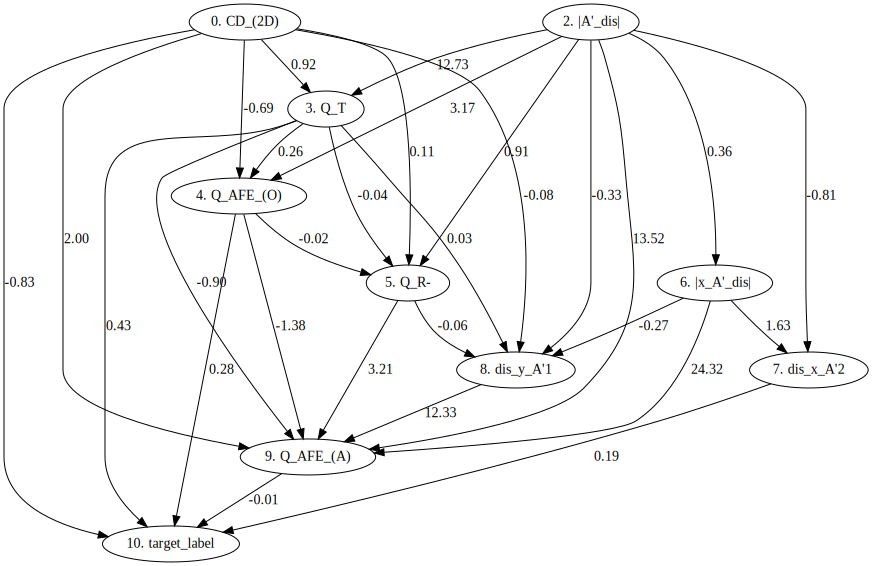

In [29]:
#create DirectLinGAM object
np.seterr(invalid="ignore")
pk = make_prior_knowledge(
    n_variables=len(X_causal.columns),
    sink_variables=[10])

model = lingam.DirectLiNGAM(prior_knowledge=pk)
model.fit(X_causal)
labels = [f'{i}. {col}' for i, col in enumerate(X_causal.columns)]
make_graph(model.adjacency_matrix_, labels)